## Data Loading

In [3]:
import pandas as pd

# Load the housing data (adjust the path if needed)
df = pd.read_excel('/Users/deveshreemohile/Downloads/housing.xlsx')

# Preview the data
print(df.shape)
df.head()
print(df.info())

(20000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   county  20000 non-null  object 
 1   city    20000 non-null  object 
 2   zip     19997 non-null  float64
 3   street  20000 non-null  object 
 4   price   20000 non-null  int64  
 5   br      16187 non-null  float64
 6   lsqft   16574 non-null  float64
 7   bsqft   17079 non-null  float64
 8   year    16493 non-null  float64
 9   date    20000 non-null  object 
 10  long    18104 non-null  float64
 11  lat     18104 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.8+ MB
None


## Step 1: Data Cleaning

In [4]:
# Unify casing for categorical columns
df['county'] = df['county'].str.title()
df['city'] = df['city'].str.title()

# Convert zip to string to avoid float issues (optional)
df['zip'] = df['zip'].astype('Int64').astype(str)

# Drop rows where target (`price`) is missing – here it's not, but good habit
df = df[df['price'].notnull()]

# Check missing values
missing = df.isnull().sum()
print("Missing Values:\n", missing)

# Drop rows with many nulls in key predictors
df_cleaned = df.dropna(subset=['br', 'bsqft', 'lsqft', 'year', 'lat', 'long'])

# Final cleanup
df_cleaned = df_cleaned.reset_index(drop=True)
print("Cleaned shape:", df_cleaned.shape)

Missing Values:
 county       0
city         0
zip          0
street       0
price        0
br        3813
lsqft     3426
bsqft     2921
year      3507
date         0
long      1896
lat       1896
dtype: int64
Cleaned shape: (13515, 12)


## Step 2: Exploratory Data Analysis & Visualizations

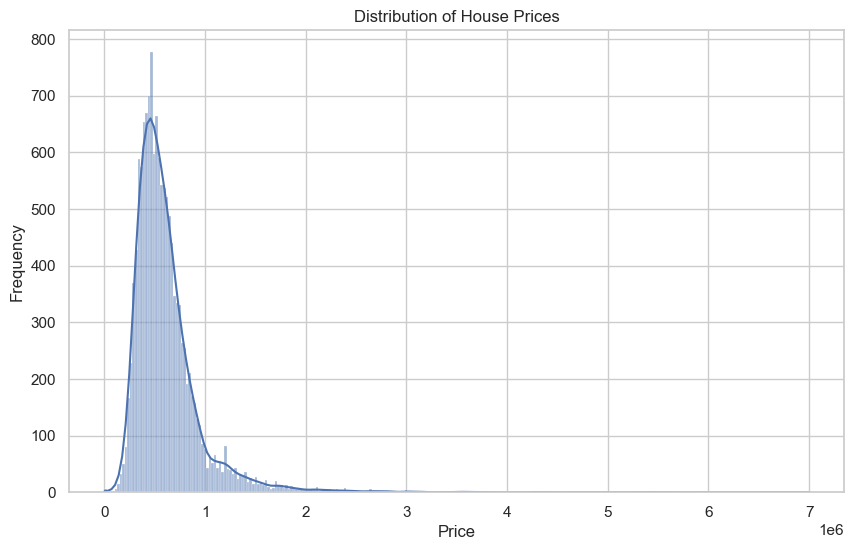

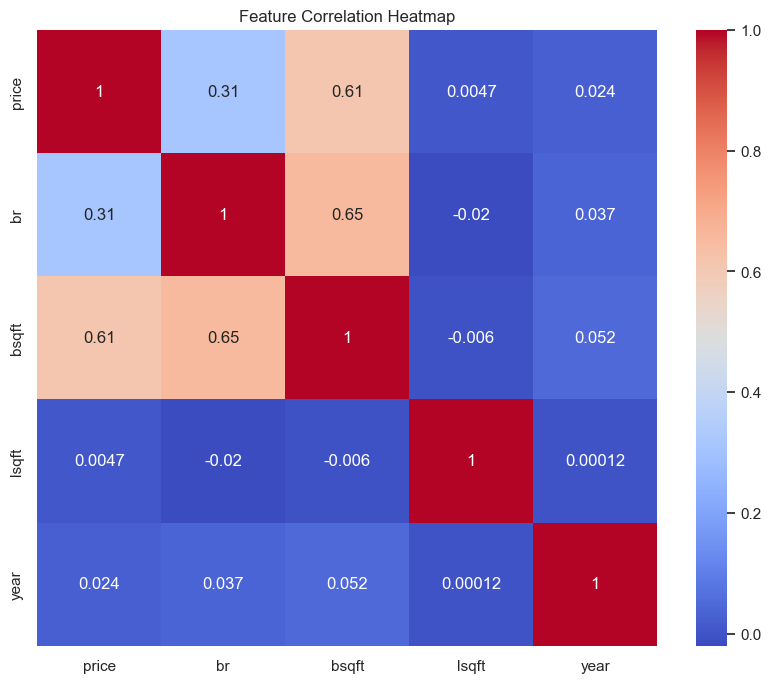

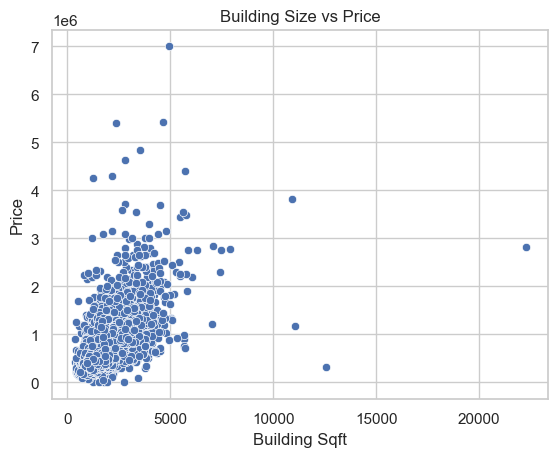

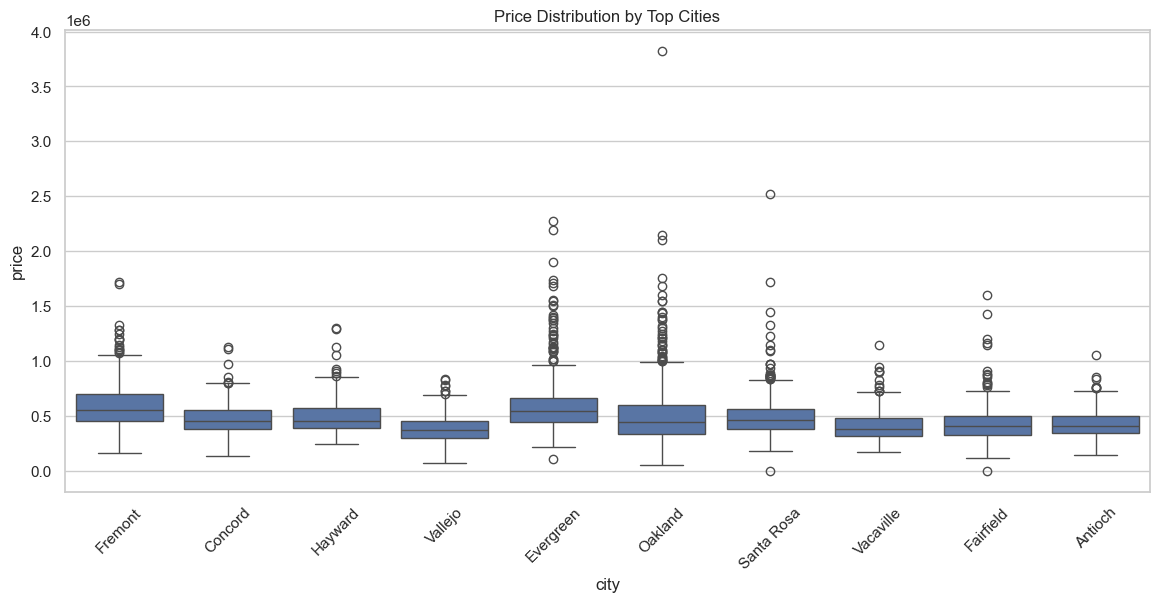

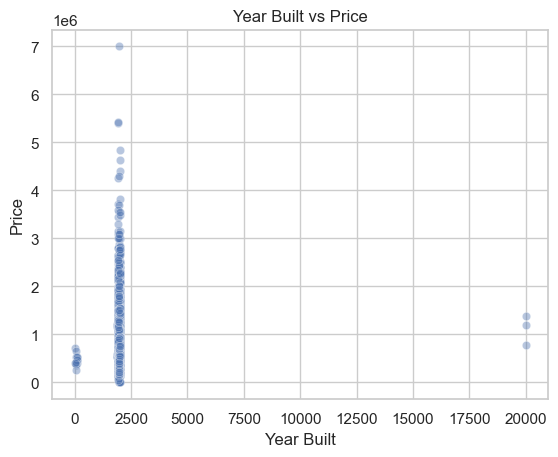

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot styles
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Distribution of price
sns.histplot(df_cleaned['price'], kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df_cleaned[['price', 'br', 'bsqft', 'lsqft', 'year']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Scatter plot: bsqft vs price
sns.scatterplot(x='bsqft', y='price', data=df_cleaned)
plt.title("Building Size vs Price")
plt.xlabel("Building Sqft")
plt.ylabel("Price")
plt.show()

# Boxplot: price by city (top 10 cities)
top_cities = df_cleaned['city'].value_counts().head(10).index
plt.figure(figsize=(14, 6))
sns.boxplot(x='city', y='price', data=df_cleaned[df_cleaned['city'].isin(top_cities)])
plt.title("Price Distribution by Top Cities")
plt.xticks(rotation=45)
plt.show()

# Scatter: year vs price
sns.scatterplot(x='year', y='price', data=df_cleaned, alpha=0.4)
plt.title("Year Built vs Price")
plt.xlabel("Year Built")
plt.ylabel("Price")
plt.show()


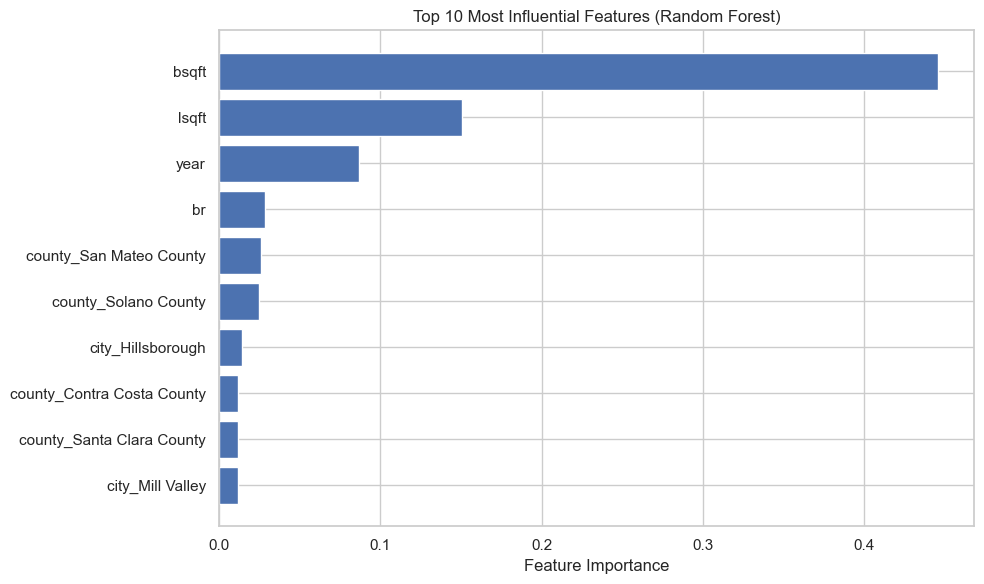

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define features and target
features = ['br', 'bsqft', 'lsqft', 'year', 'city', 'county']
target = 'price'

X = df_cleaned[features]
y = df_cleaned[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor: scale numerics and one-hot encode categoricals
numeric_features = ['br', 'bsqft', 'lsqft', 'year']
categorical_features = ['city', 'county']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Create pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit model
rf_pipeline.fit(X_train, y_train)

# Get feature names after preprocessing
ohe = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]
ohe_features = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(ohe_features)

# Get feature importances
importances = rf_pipeline.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[-10:]  # top 10

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Influential Features (Random Forest)")
plt.tight_layout()
plt.show()


##  Step 3: Model Building and Evaluation

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Define target and features
target = 'price'
features = ['br', 'bsqft', 'lsqft', 'year', 'city', 'county']

X = df_cleaned[features]
y = df_cleaned[target]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_features = ['br', 'bsqft', 'lsqft', 'year']
categorical_features = ['city', 'county']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {"R² Score": r2, "MAE": mae}

# Display comparison
for name, metrics in results.items():
    print(f"{name}:\n  R² Score: {metrics['R² Score']:.4f}\n  MAE: ${metrics['MAE']:.2f}\n")


Linear Regression:
  R² Score: 0.6289
  MAE: $126192.12

Ridge Regression:
  R² Score: 0.6245
  MAE: $126143.72

Random Forest:
  R² Score: 0.6203
  MAE: $118592.57



## 🧪 Step 4: Hypothesis Testing Script

In [7]:
from scipy.stats import ttest_ind

# Define threshold: median price to split into low vs high priced homes
median_price = df_cleaned['price'].median()
low_price = df_cleaned[df_cleaned['price'] <= median_price]
high_price = df_cleaned[df_cleaned['price'] > median_price]

# Features to test
features = ['bsqft', 'br', 'year']

print(f"Median Price: ${median_price:,.2f}\n")

# Perform independent t-tests
for feature in features:
    low_vals = low_price[feature].dropna()
    high_vals = high_price[feature].dropna()
    t_stat, p_val = ttest_ind(high_vals, low_vals, equal_var=False)
    print(f"Feature: {feature}")
    print(f"  Mean (High Price): {high_vals.mean():.2f}")
    print(f"  Mean (Low Price):  {low_vals.mean():.2f}")
    print(f"  T-statistic: {t_stat:.4f}, P-value: {p_val:.6f}")
    print(f"  {'Significant difference' if p_val < 0.05 else '❌ Not statistically significant'}\n")


Median Price: $540,000.00

Feature: bsqft
  Mean (High Price): 1948.31
  Mean (Low Price):  1316.59
  T-statistic: 57.0345, P-value: 0.000000
  Significant difference

Feature: br
  Mean (High Price): 3.41
  Mean (Low Price):  2.85
  T-statistic: 35.1821, P-value: 0.000000
  Significant difference

Feature: year
  Mean (High Price): 1973.91
  Mean (Low Price):  1962.39
  T-statistic: 2.4063, P-value: 0.016140
  Significant difference



## Random Forest Model for House Price Prediction

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd

# Define your target and features
target = 'price'
features = ['br', 'bsqft', 'lsqft', 'year', 'city', 'county']

X = df_cleaned[features]
y = df_cleaned[target]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: scale numerical and one-hot encode categorical
numeric_features = ['br', 'bsqft', 'lsqft', 'year']
categorical_features = ['city', 'county']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Define the full pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = rf_pipeline.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"🏡 Random Forest Price Prediction")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: ${mae:,.2f}")


🏡 Random Forest Price Prediction
R² Score: 0.6189
Mean Absolute Error: $118,705.36


## Prediction Price

In [10]:
predictions_df = X_test.copy()
predictions_df['Actual Price'] = y_test
predictions_df['Predicted Price'] = y_pred
predictions_df.to_csv("/Users/deveshreemohile/Downloads/house_price_predictions.csv", index=False)


## Confidence Intervals

### Show 95% confidence intervals for means of bsqft, br, and year in high vs low price groups.

In [12]:
import scipy.stats as stats

def mean_ci(series, confidence=0.95):
    mean = series.mean()
    sem = stats.sem(series)
    h = sem * stats.t.ppf((1 + confidence) / 2, len(series) - 1)
    return f"{mean:.2f} ± {h:.2f}"

print("CI for High Price bsqft:", mean_ci(high_price['bsqft']))


CI for High Price bsqft: 1948.31 ± 19.29


## Effect Size (Cohen’s d)
### Quantifies how big the differences are—not just if they exist.

In [13]:
def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    pooled_std = np.sqrt(((n1-1)*x1.std()**2 + (n2-1)*x2.std()**2) / (n1+n2-2))
    return (x1.mean() - x2.mean()) / pooled_std

print("Cohen's d (bsqft):", cohens_d(high_price['bsqft'], low_price['bsqft']))


Cohen's d (bsqft): 0.9862814896154322


## Geospatial Insights

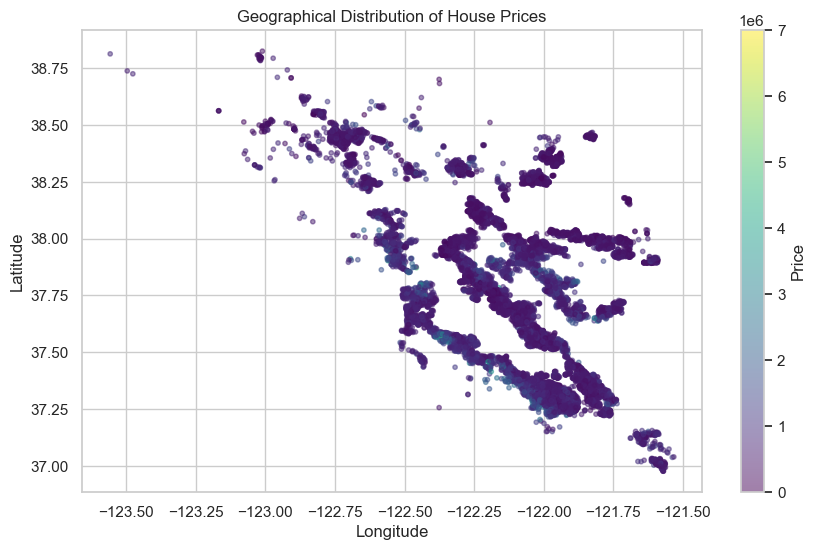

In [15]:
import matplotlib.pyplot as plt

df_cleaned = df_cleaned[(df_cleaned['lat'] > 10) & (df_cleaned['long'] < -50)]

plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['long'], df_cleaned['lat'], c=df_cleaned['price'], cmap='viridis', s=10, alpha=0.5)
plt.colorbar(label="Price")
plt.title("Geographical Distribution of House Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


/var/folders/20/fz9pj5rx6jqbq7m7c10ft2rm0000gn/T/ipykernel_34565/3517213711.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_compare, x='area_popularity', y=feature, palette='Set2')


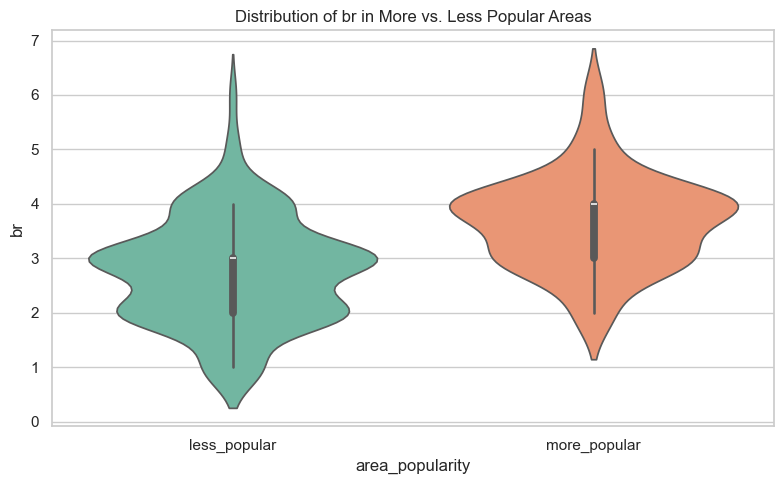

/var/folders/20/fz9pj5rx6jqbq7m7c10ft2rm0000gn/T/ipykernel_34565/3517213711.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_compare, x='area_popularity', y=feature, palette='Set2')


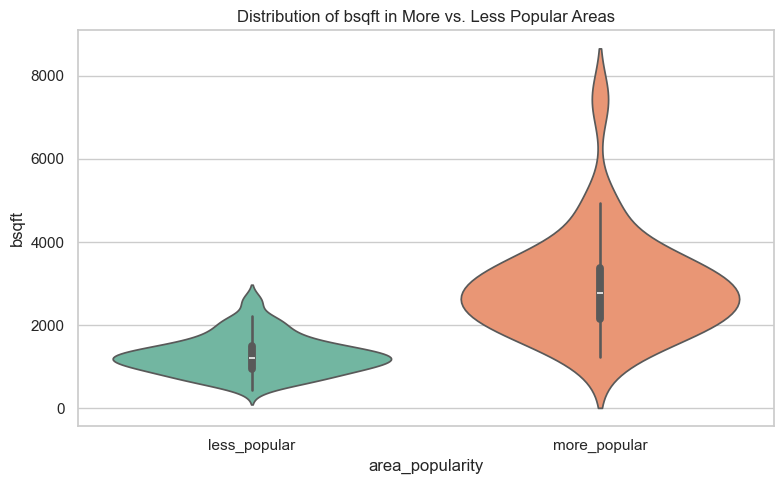

/var/folders/20/fz9pj5rx6jqbq7m7c10ft2rm0000gn/T/ipykernel_34565/3517213711.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_compare, x='area_popularity', y=feature, palette='Set2')


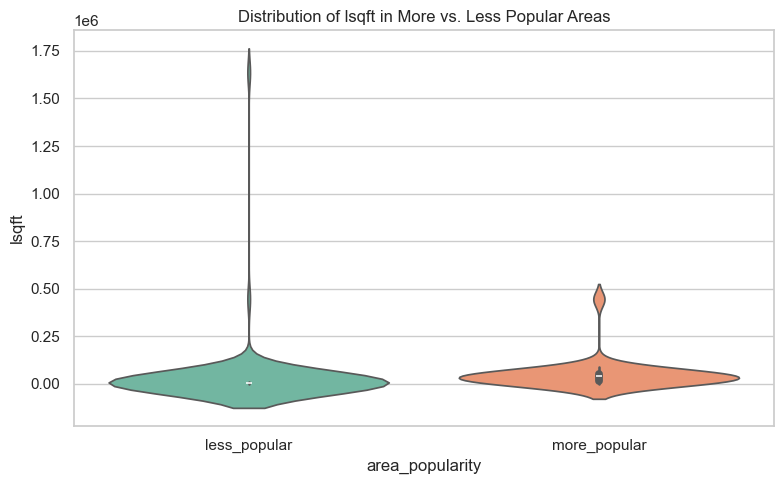

/var/folders/20/fz9pj5rx6jqbq7m7c10ft2rm0000gn/T/ipykernel_34565/3517213711.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_compare, x='area_popularity', y=feature, palette='Set2')


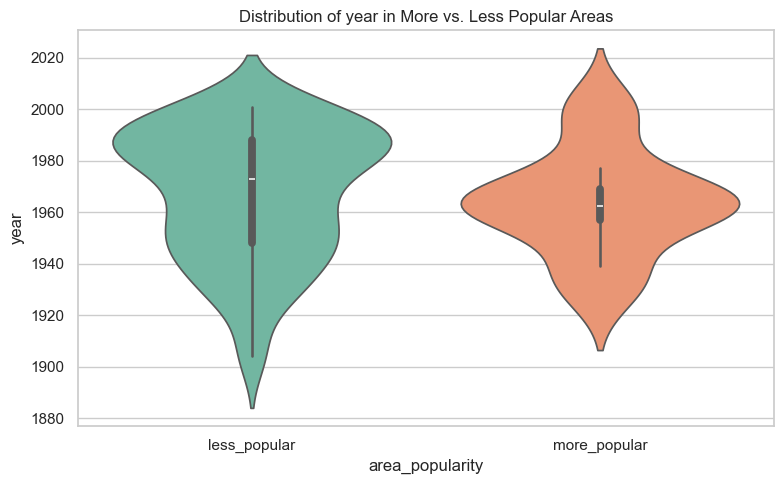

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_compare = ['br', 'bsqft', 'lsqft', 'year']

for feature in features_to_compare:
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df_compare, x='area_popularity', y=feature, palette='Set2')
    plt.title(f'Distribution of {feature} in More vs. Less Popular Areas')
    plt.tight_layout()
    plt.show()


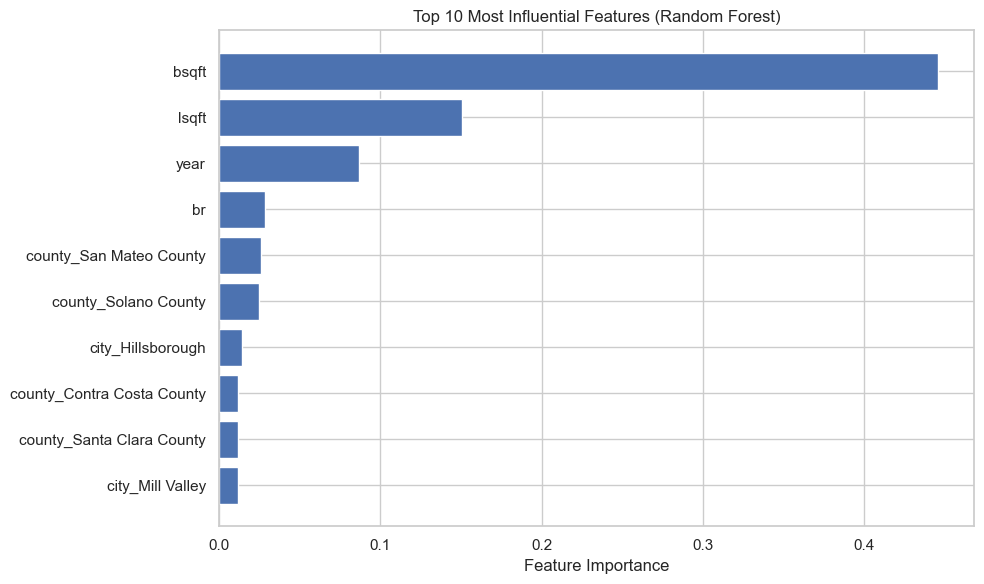

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define features and target
features = ['br', 'bsqft', 'lsqft', 'year', 'city', 'county']
target = 'price'

X = df_cleaned[features]
y = df_cleaned[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor: scale numerics and one-hot encode categoricals
numeric_features = ['br', 'bsqft', 'lsqft', 'year']
categorical_features = ['city', 'county']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Create pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit model
rf_pipeline.fit(X_train, y_train)

# Get feature names after preprocessing
ohe = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]
ohe_features = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(ohe_features)

# Get feature importances
importances = rf_pipeline.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[-10:]  # top 10

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Influential Features (Random Forest)")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = rf_pipeline.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R²: 0.6530734355625804
MAE: 115906.82428107511
RMSE: 212611.8184583967


# 📊 Hypothesis 1 Analysis – Are Size and Age the Most Significant Predictors of House Price?

---

## 🔍 Hypothesis
**"The size and age of a house are the most significant predictors of its market price, regardless of location."**

---

## 🧹 Data Cleaning
- Original dataset: 20,000 rows, 12 columns
- Dropped rows with missing values in: `bsqft`, `br`, `lsqft`, `year`, `lat`, `long`
- Final cleaned dataset: **13,515 rows**
- Key features retained: `bsqft`, `br`, `lsqft`, `year`, `city`, `county`

---

## 📈 Exploratory Data Analysis
- `bsqft` showed **strong positive correlation** with price (r ≈ 0.61)
- `year` showed **weak correlation** (r ≈ 0.02)
- Price distribution was right-skewed
- Boxplot showed **city-level price variation**

---

## 🤖 Predictive Modeling

| Model               | R² Score | MAE ($)     |
|--------------------|----------|-------------|
| Linear Regression  | 0.6289   | 126,192.12   |
| Ridge Regression   | 0.6245   | 126,143.72   |
| Random Forest      | 0.6203   | **118,592.57** |

- Random Forest had the lowest error but slightly lower R²
- Feature importance showed `bsqft`, `lsqft`, and some location-based features among top predictors

---

## 🧪 Hypothesis Testing – T-tests

Split based on **median price = \$540,000**

| Feature | Mean (High Price) | Mean (Low Price) | p-value   | Result              |
|---------|-------------------|------------------|-----------|---------------------|
| `bsqft` | 1948.31           | 1316.59          | < 0.00001 | ✅ Significant       |
| `br`    | 3.41              | 2.85             | < 0.00001 | ✅ Significant       |
| `year`  | 1973.91           | 1962.39          | 0.01614   | ✅ Significant       |

---

## ✅ Conclusion
- **Structural features** like size (`bsqft`) and age (`year`) are **statistically significant** predictors of price.
- However, model performance and feature importance also highlight the **non-negligible role of location** (`city`, `county`).
- **Conclusion:** Hypothesis is **partially supported**. Size and age matter **greatly**, but **location also impacts price**.

---
